<a href="https://colab.research.google.com/github/Akage1234/Pytorch-mini-projects/blob/main/ComputerVision/TransferLearning_ImageClassification/CatsVsDogs_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dataset

In [35]:
import torch
device = ("cuda" if torch.cuda.is_available() else "cpu")
print("using device: ", device)

using device:  cuda


In [36]:
# seeds for reproducibility
import random
import numpy as np

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)                          # cpu
torch.cuda.manual_seed(42)                     # gpu
torch.cuda.manual_seed_all(42)                 # multiple gpus
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Import from kaggle

In [ ]:
from google.colab import files
key = files.upload()

In [38]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [39]:
!pip install -q kaggle

In [40]:
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
cat-and-dog.zip: Skipping, found more recently modified local copy (use --force to force download)


Alternatively, download dataset from https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset?select=PetImages and upload the zip file

In [41]:
!mkdir -p data/catsdogs
!unzip -q cat-and-dog.zip -d data/catsdogs

replace data/catsdogs/test_set/test_set/cats/_DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/catsdogs/test_set/test_set/cats/cat.4001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/catsdogs/test_set/test_set/cats/cat.4002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [42]:
# Train/Test Split
import os, random, shutil
from pathlib import Path

data_dir = Path("data/catsdogs/training_set/training_set/")
cats = list((data_dir / "cat").glob("*.jpg"))
dogs = list((data_dir / "dog").glob("*.jpg"))

for split in ['train', 'val']:
    for cls in ['dog', 'cat']:
        os.makedirs(f'data/{split}/{cls}', exist_ok = True)

random.shuffle(cats)
random.shuffle(dogs)

split_id_cats = int(0.8 * len(cats))
split_id_dogs = int(0.8 * len(dogs))

In [43]:
for i, path in enumerate(cats):
    dest = "train" if i< split_id_cats else "val"
    shutil.copy(path, f"data/{dest}/cat/")

for i, path in enumerate(dogs):
    dest = "train" if i< split_id_dogs else "val"
    shutil.copy(path, f"data/{dest}/dog/")

In [44]:
# Creating the Datasets & DataLoaders

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("data/train", transform=train_transforms)
val_dataset = datasets.ImageFolder("data/val", transform=val_transforms)

train_loader = DataLoader(train_dataset, 64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, 64, shuffle=True, num_workers=2, pin_memory=True)

print(train_dataset.classes)
print(train_dataset.class_to_idx)

['cats', 'dogs']
{'cats': 0, 'dogs': 1}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [45]:
!pip install torchinfo

y


In [65]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 47.0 MB/s eta 0:00:00


In [83]:
# Loading Model
from torchvision import models
from torchinfo import summary

model = models.resnet18(pretrained=True)
summary(model, input_size=(1,3,224, 224))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [84]:
import torch.nn as nn

# Freezing layers
for p in model.parameters():
    p.requires_grad=False

# Replacing Classifier
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
for p in model.fc.parameters():
    p.requires_grad = True
model = model.to(device)

In [85]:
model.fc.out_features

2

In [86]:
import torch.optim as optim
from  torchmetrics.classification import Accuracy

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

In [87]:
n_epochs = 5

metric = Accuracy(task='multiclass', num_classes=2).to(device)

for epoch in range(n_epochs):
    model.train()
    # training
    total_loss = 0.0
    metric.reset()

    for batch_images, batch_labels in train_loader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        pred = model(batch_images)
        loss = criterion(pred, batch_labels)
        metric.update(pred, batch_labels)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy = metric.compute().item() * 100
    metric.reset()
    avg_loss = total_loss/len(train_loader)
    # evaluation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            pred = model(images)
            metric.update(pred, labels)
            loss = criterion(pred, labels)
            val_loss += loss.item()

    val_accuracy = metric.compute().item() * 100
    avg_val_loss = val_loss/ len(val_loader)
    print(f"Epoch:{epoch+1}/{n_epochs} | loss: {avg_loss:.4f} | train_accuracy: {train_accuracy:.2f}% | val_loss: {avg_val_loss:.4f} | val_accuracy: {val_accuracy:.2f}%")

Epoch:1/5 | loss: 0.2634 | train_accuracy: 89.40% | val_loss: 0.1161 | val_accuracy: 96.19%
Epoch:2/5 | loss: 0.1045 | train_accuracy: 96.72% | val_loss: 0.0862 | val_accuracy: 97.10%
Epoch:3/5 | loss: 0.0894 | train_accuracy: 96.81% | val_loss: 0.0705 | val_accuracy: 97.58%
Epoch:4/5 | loss: 0.0805 | train_accuracy: 96.94% | val_loss: 0.0615 | val_accuracy: 97.97%
Epoch:5/5 | loss: 0.0779 | train_accuracy: 97.30% | val_loss: 0.0551 | val_accuracy: 98.03%


In [89]:
# unfreezing last layer
for p in model.layer4.parameters():
    p.requires_grad = True

model.train()
learning_rate = 1e-4
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': 1e-3},
    {'params': model.layer4.parameters(), 'lr': 1e-4}
])

In [90]:
n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    # training
    total_loss = 0.0
    metric.reset()

    for batch_images, batch_labels in train_loader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        pred = model(batch_images)
        loss = criterion(pred, batch_labels)
        metric.update(pred, batch_labels)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy = metric.compute().item() * 100
    metric.reset()
    avg_loss = total_loss/len(train_loader)
    # evaluation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            pred = model(images)
            metric.update(pred, labels)
            loss = criterion(pred, labels)
            val_loss += loss.item()

    val_accuracy = metric.compute().item() * 100
    avg_val_loss = val_loss/ len(val_loader)
    print(f"Epoch:{epoch+1}/{n_epochs} | loss: {avg_loss:.4f} | train_accuracy: {train_accuracy:.2f}% | val_loss: {avg_val_loss:.4f} | val_accuracy: {val_accuracy:.2f}%")

Epoch:1/5 | loss: 0.0764 | train_accuracy: 97.24% | val_loss: 0.0269 | val_accuracy: 98.97%
Epoch:2/5 | loss: 0.0260 | train_accuracy: 99.00% | val_loss: 0.0047 | val_accuracy: 99.88%
Epoch:3/5 | loss: 0.0062 | train_accuracy: 99.83% | val_loss: 0.0007 | val_accuracy: 100.00%
Epoch:4/5 | loss: 0.0021 | train_accuracy: 99.97% | val_loss: 0.0002 | val_accuracy: 100.00%
Epoch:5/5 | loss: 0.0081 | train_accuracy: 99.98% | val_loss: 0.0008 | val_accuracy: 100.00%


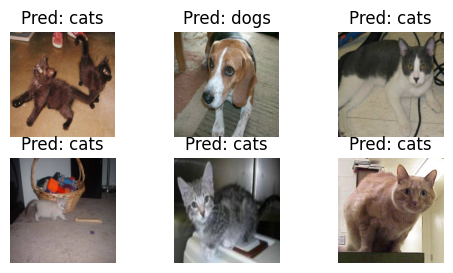

In [91]:
import matplotlib.pyplot as plt
import torchvision

images, labels = next(iter(val_loader))
images, labels = images[:6], labels[:6]

images = images.cpu()
labels = labels.cpu()
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

unnormalize = torchvision.transforms.Normalize(
    mean=[-m/s for m, s in zip(mean,std)],
    std=[1/s for s in std]
)

model.eval()
with torch.no_grad():
    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(6,3))
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1)
    img = unnormalize(images[i])
    img = torch.clamp(img, 0, 1)
    ax.imshow(img.permute(1,2,0))
    ax.set_title(f"Pred: {val_dataset.classes[preds[i]]}")
    ax.axis('off')
plt.show()

# Evaluation

In [92]:
from torchvision import datasets, transforms

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder("data/catsdogs/test_set/test_set/", transform=test_transform)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=64, num_workers=2, pin_memory=True)

In [94]:
model.eval()
accuracy_metric = Accuracy(task='multiclass', num_classes=2).to(device)

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        accuracy_metric.update(outputs, labels)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

test_accuracy = accuracy_metric.compute().item() * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Flattening
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

Test Accuracy: 98.07%


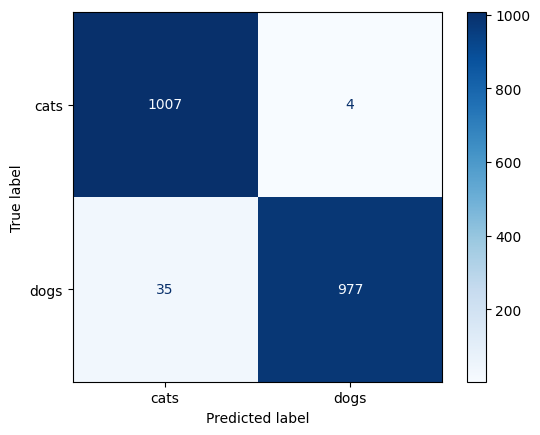

In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap='Blues')

In [99]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

              precision    recall  f1-score   support

        cats       0.97      1.00      0.98      1011
        dogs       1.00      0.97      0.98      1012

    accuracy                           0.98      2023
   macro avg       0.98      0.98      0.98      2023
weighted avg       0.98      0.98      0.98      2023



In [101]:
# Saving the model
torch.save(model.state_dict(), "resnet18_catsdogs.pth")